In [378]:
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os 

TITANIC_PATH = 'datasets/titanic'

def load_titanic_data(titanic_path=TITANIC_PATH):
    train_path = os.path.join(titanic_path, 'train.csv')
    test_path = os.path.join(titanic_path, 'test.csv')

load_titanic_data()

In [379]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [380]:
X = train_data.drop('Survived', axis = 1)
y = train_data.Survived

In [381]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [382]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [383]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [384]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

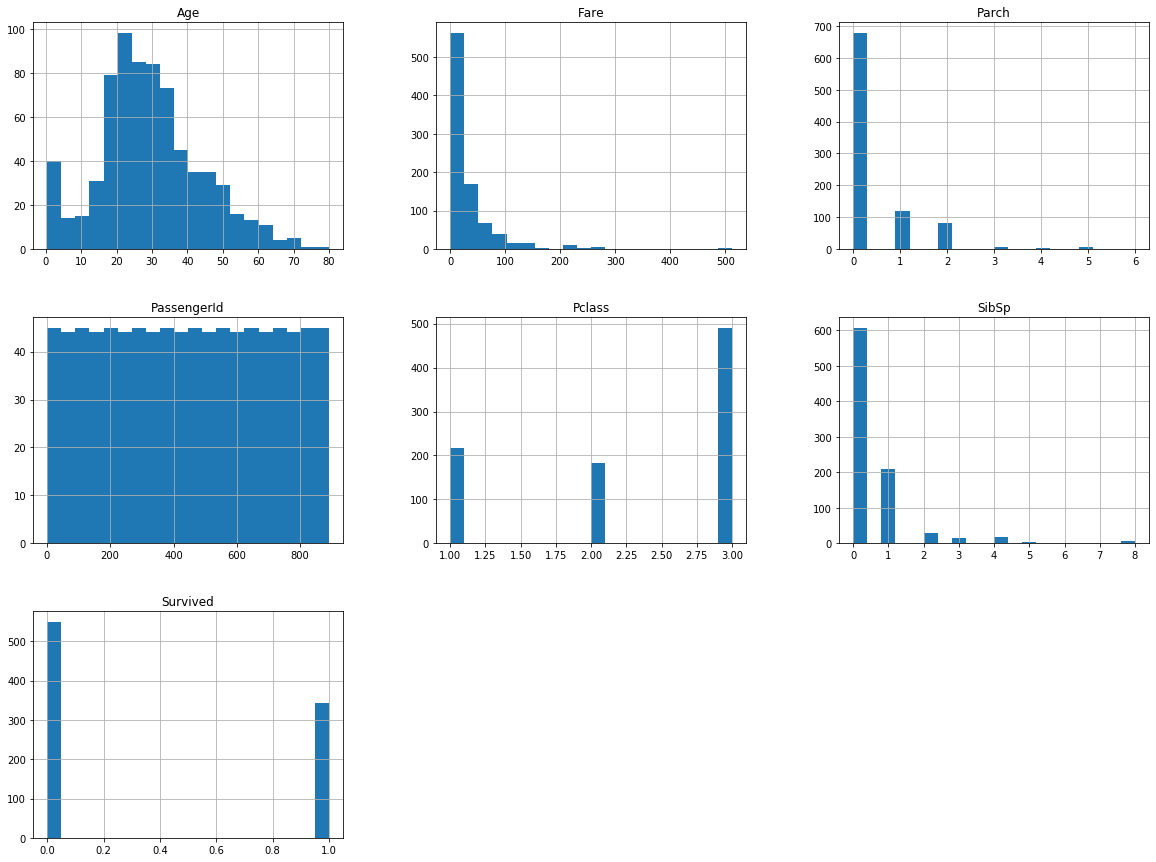

In [385]:
train_data.hist(bins=20, figsize=(20,15))
plt.show()

In [386]:
fares = train_data['Fare']
fares.nlargest(n=5)

258    512.3292
679    512.3292
737    512.3292
27     263.0000
88     263.0000
Name: Fare, dtype: float64

In [387]:
fares.nsmallest(n=5)

179    0.0
263    0.0
271    0.0
277    0.0
302    0.0
Name: Fare, dtype: float64

In [388]:
corr_matrix = train_data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [389]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [390]:
num_attrs = ['Age', 'Fare', 'Parch', 'Pclass']

num_pipeline = Pipeline([
    ('tuning', ParameterTuning()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ])

In [391]:
cat_attrs = ['Sex', 'Embarked']

cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [392]:
preprocessor = ColumnTransformer([
    ('num_processing', num_pipeline, num_attrs),
    ('cat_processing', cat_pipeline, cat_attrs),
])

In [393]:
pipeline = Pipeline ([
    ('preprocessing', preprocessor),
    ('clf', SVC())
])

In [394]:
params = [
    {
        'clf': [SVC()],   
        'clf__gamma': ['auto'],
        'preprocessing__num_processing__scaler': [StandardScaler(), 'passthrough'],
        'preprocessing__num_processing__imputer__strategy': ['mean', 'median'],
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [5, 8],
        'clf__random_state': [42],
        'preprocessing__num_processing__scaler': [StandardScaler(), 'passthrough'],
        'preprocessing__num_processing__imputer__strategy': ['mean', 'median'],
    }  
]

In [395]:
cv = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy')
cv.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_processing',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('tuning',
                                                                                          ParameterTuning(dropna=False,
                                                                                                          parch=True)),
                         

In [396]:
cv.best_params_

{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=8, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=50,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 'clf__max_depth': 8,
 'clf__n_estimators': 50,
 'clf__random_state': 42,
 'preprocessing__num_processing__imputer__strategy': 'mean',
 'preprocessing__num_processing__scaler': 'passthrough'}

In [397]:
cv.best_score_

0.8316427091833531

In [398]:
forest_scores = cross_val_score(cv.best_estimator_, X, y, cv=10)
forest_scores.mean()

0.8283021223470662